# TESS Sector 1751: 3I/ATLAS

This notebook show examples of how to open and inspect the images and light curve data contained in the FITS files created by the 
TSSC. Here you'll find examples on how to use the `lightkurve` package to properly open the `tp` and `lc` files and similarly using the FITS reader and Tables from `astropy`. 

To run this tutorial you will need `astropy` and `lightkurve` Python packages. We recommend installing this in a new python environment, which can be done with conda.

```bash
# create new env with conda and Python 3.10
conda create -n tess-3i python=3.10
# activate new env
conda activate tess-3i
# install tess-asteroids (latest stable version)
pip install lightkurve==2.5.0
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

from astropy.io import fits
from astropy.stats import sigma_clipped_stats, sigma_clip, median_absolute_deviation
from astropy.table import Table

## Target Pixel File

The `tp` files contain the pixel time series centered on 3I/ATLAS. The center is rounded to the pixel integer value, which means no image registration or resampling was applied. The images are background subtracted, which means that the background sacattered light (from Earh and Moon) and the star field was modeled and subtracted for every frame. For details on how these signals are modeled see the `tess-asteroids` documentation [here](https://altuson.github.io/tess-asteroids/movingtpf/#tess_asteroids.MovingTPF.background_correction). The times are corrected by differential velocity aberration and are in TDB scale at the barycenter, see here for [more details](https://github.com/altuson/tess-asteroids).
The FITS files also contains the background model per frame, so if you prefer to go back to the original pixel flux values and perform your own background modeling this is possible. We'll show how to do that later in this tutorial. 


First, let's inspect the `tp` FITS file and see what's inside:

In [2]:
# file version
version = "1.2"

In [3]:
hdul_tpf = fits.open(
    f"../../data/2026/hlsp_tess-3i_tess_ffi_3iatlas-s1751-cam2-ccd3_tess_v{version}_tp.fits"
)
hdul_tpf.info()

Filename: ../../data/2026/hlsp_tess-3i_tess_ffi_3iatlas-s1751-cam2-ccd3_tess_v1.2_tp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      59   ()      
  1  PIXELS        1 BinTableHDU    204   1835R x 10C   [D, E, I, 8281E, 8281E, 8281E, 8281E, J, E, E]   
  2  APERTURE      1 ImageHDU        43   (91, 91)   int32   
  3  EXTRAS        1 BinTableHDU     40   1835R x 8C   [D, E, E, E, I, I, 8281I, 8281J]   


The primary header contains all the metadata and target information. These are very similar to the headers in SPOC TPFs.

In [4]:
hdul_tpf[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'TSSC    '           / institution responsible for creating this file 
DOI     = '10.17909/zefb-7f89' / Digital Object Identifier for the HLSP data col
HLSPID  = 'TESS-3I '           / The identifier (acronym) for this HLSP collecti
HLSPLEAD= 'Jorge Martinez-Palomera' / Full name of HLSP project lead            
HLSPNAME= 'TSSC comet-centered data products from TESS 3I/ATLAS observations' / 
HLSPTARG= '3I/ATLAS'           / Designation of the target(s) or field(s) for th
HLSPVER = '1.1     '           / Version identifier for this HLSP product       
LICENSE = 'CC BY 4.0'       

Here' we see 4 extension:
* **PRIMARY** : contains the basic header information for the target, data reduction and extraction pipelines, dates, etc.
* **PIXELS** : contains the pixel time series information, flux, background fluxes, and quality flags.
* **APERTURE** : has the pixel aperture mask summed across all times. This mask is meaningless for 3I, as we used two mask for aperture photometry which cover the core and the core plus tail. This extension is here to comply with TESS-SPOC-like formatting so we can use `lightkurve` to open the files.
* **EXTRAS** : contains extra array information such as the pixel corner values for every frame, predicted positions of the object in world coordinates, original times as seen in the FFI data, aperture mask per frame, and pixel quality per frame. 


Now, let's open the `tp` file with `lightkurve`:

In [5]:
tpf = lk.TessTargetPixelFile(
    f"../../data/2026/hlsp_tess-3i_tess_ffi_3iatlas-s1751-cam2-ccd3_tess_v{version}_tp.fits",
    quality_bitmask="none",  # we set quality_bitmask to none to see all data
)
tpf.target = "3I/ATLAS"  # set a more user-friendly name for plots
tpf

/Users/jimartin/miniforge3/envs/tess-asteroids/lib/python3.10/site-packages/lightkurve/targetpixelfile.py:2796: LightkurveWarning: File header not recognized as Kepler or TESS observation.
  warnings.warn(


TessTargetPixelFile(TICID: None)

In [6]:
tpf.flux.shape, tpf.time.shape

((1835, 91, 91), (1835,))

Our TPF has shape [nt, pix_v, pix_h], which in this case is [xxx, yyy, zzz].
The time attribute has the time vector as an astropy quantity which supports time conversion. The default format is Barycenter TESS JD (BTJD = JD - 2457000)

In [7]:
tpf.time

<Time object: scale='tdb' format='btjd' value=[4055.75926138 4055.76157631 4055.76389123 ... 4063.00016907 4063.00248388
 4063.00479869]>

We can use the built-in plot method to display specific frames and also the default aperture in the **APERTURE** extension, remember this aperture is NOT the one used for the photometry.

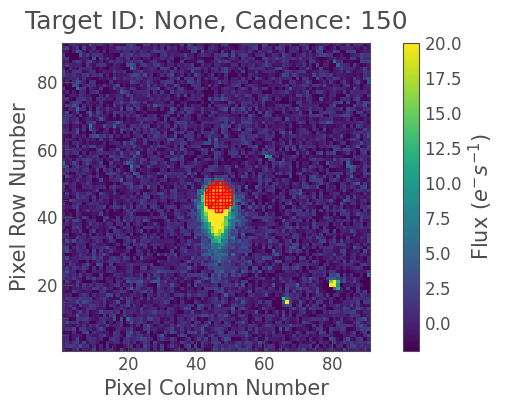

In [8]:
nt = 150
tpf.plot(frame=nt, aperture_mask="default", vmin=-2, vmax=20)
plt.show()

We an also plot the median-stack image (only good SPOC quality frames) like this:

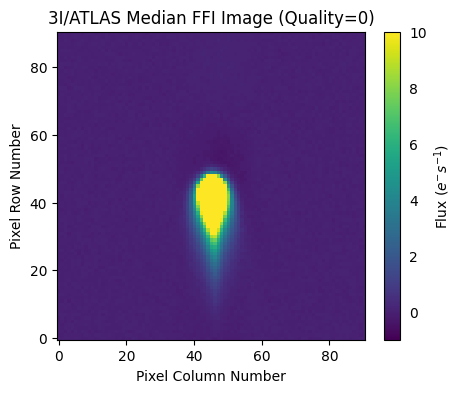

In [9]:
fig, ax = plt.subplots(figsize=(5,4))
lk.targetpixelfile.plot_image(
    sigma_clipped_stats(tpf.flux[tpf.quality == 0], axis=0)[1], 
    title=f"{tpf.target} Median FFI Image (Quality=0)",
    vmin=-1,
    vmax=10,
    ax=ax,
    )
plt.savefig(
    "../../data/2026/figures/tess_3iatlas_spoc_s1751_med_stack.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [10]:
# this is the SPOC quality flag array
tpf.quality

array([ 8,  0,  0, ..., 32, 32, 32], dtype='>i4')

The SPOC quality flags mark cadences with anomalies, in this case the first cadence has the flag `8` which means "Spacecraft is inEarthPoint".

We can inspect the HDU tables in each extension to see what columns are in each table:

For the main table:
* **TIME** is the mid-point of the observation time in TDB at the barycenter.
* **TIMECORR** is the time correction value that accounts for differential velocity aberration using [lkspacecraft](https://lightkurve.github.io/lkspacecraft/)
* **FLUX and FLUX_ERR** are the pixel flux values corrected by background signal, shape is [nt, 11, 11].
* **FLUX_BKG and FLUX_BKG_ERR** are the pixel flux values of the background model, shape is [nt, 11, 11].
* **QUALITY** is the SPOC quality flag for each frame, see the [Handbook document](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/active-missions/tess/_documents/EXP-TESS-ARC-ICD-TM-0014-Rev-F.pdf) for details.
* **POS_CORR1 and POS_CORR2** are the offset values from the center where the comet is expected to be according to its ephemeris. 

For the EXTRA extension:
* **ORIGINAL_TIME and ORIGINAL_TIMECORR** are the original time and correction values as seen in the FFI data and derived by the SPOC pipeline, which does not account for differential velocity aberration. 
* **RA_PRED and DEC_PRED** are the predicted world coordinates of the comet according to its ephemeris.
* **CORNER1 and CORNER2** are the pixel number values of the lower-left corner of the cutout.
* **PIXEL_QUALITY** is the pixel quality mask derived by `tess-asteroids` which marks saturated pixels, bleed columns, bad background models, etc, see the [API documentation](https://altuson.github.io/tess-asteroids/movingtpf/#tess_asteroids.MovingTPF.create_pixel_quality) for the list of bits.
* **APERTURE** is the 3D aperture mask as a function of time, shape is [nt, 11, 11].

In [11]:
tpf.hdu[1].data.columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'I'
    name = 'FLUX'; format = '8281E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(91, 91)'
    name = 'FLUX_ERR'; format = '8281E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(91, 91)'
    name = 'FLUX_BKG'; format = '8281E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(91, 91)'
    name = 'FLUX_BKG_ERR'; format = '8281E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(91, 91)'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'POS_CORR1'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'POS_CORR2'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
)

In [12]:
tpf.hdu[3].data.columns

ColDefs(
    name = 'ORIGINAL_TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'ORIGINAL_TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'RA_PRED'; format = 'E'; unit = 'deg'; disp = 'E14.7'
    name = 'DEC_PRED'; format = 'E'; unit = 'deg'; disp = 'E14.7'
    name = 'CORNER1'; format = 'I'; unit = 'pixel'
    name = 'CORNER2'; format = 'I'; unit = 'pixel'
    name = 'PIXEL_QUALITY'; format = '8281I'; disp = 'B16.16'; dim = '(91, 91)'
    name = 'APERTURE'; format = '8281J'; dim = '(91, 91)'
)

We can inspect the aperture mask (NOT used for photometry - left) and the pixel quality mask (right). The pixel makred in the quality mask are mostly near saturated pixels (or above the linear response ~1e5).

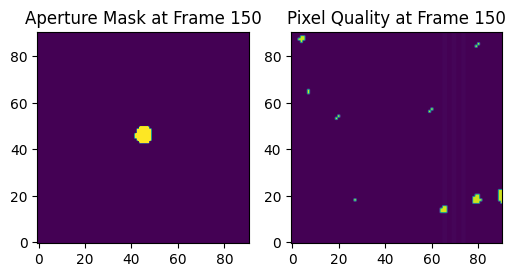

In [13]:
ap_mask = tpf.hdu[3].data['APERTURE']
pix_q = tpf.hdu[3].data["PIXEL_QUALITY"]

fig, ax = plt.subplots(1,2,figsize=(6, 6))
ax[0].imshow(ap_mask[nt], origin="lower", cmap="viridis", vmin=0, vmax=1)
ax[0].set_title(f"Aperture Mask at Frame {nt}")

ax[1].imshow(pix_q[nt], origin="lower", cmap="viridis", vmin=0, vmax=pix_q.max())
ax[1].set_title(f"Pixel Quality at Frame {nt}")
plt.show()

### Revert to Original Flux Values
If you prefer to do your own background modeling, you will need to revert back to the original flux values as seen in the FFIs.
We can do this by simply adding the `FLUX` and `FLUX_BKG` and propagating the errors accordingly.

In [14]:
org_flux = tpf.flux + tpf.flux_bkg
org_flux_err = np.sqrt(tpf.flux_bkg_err**2 + tpf.flux_bkg**2)

org_flux.shape

(1835, 91, 91)

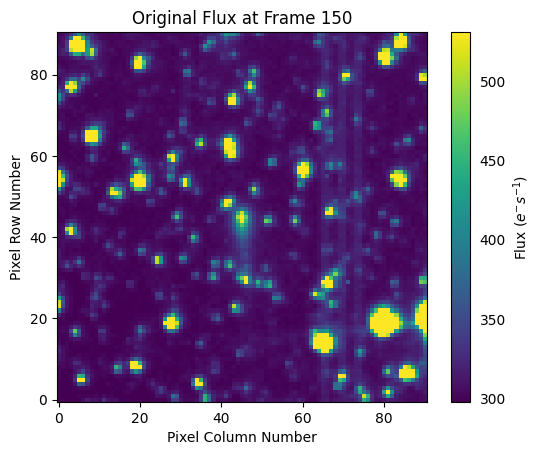

In [15]:
lk.targetpixelfile.plot_image(
    org_flux[nt],
    title=f"Original Flux at Frame {nt}",
)
plt.show()


## Light Curve File

Now let's inspect the light curve files. These are light curves extracted from the centered TPF we saw above using aperture and PSF photometry. The FITS file are structured similarly to SPOC `lc` files, but with extra information because our target is moving across the image.

First, we see what's in the FITS file:

In [16]:
hdul_lcf = fits.open(
    f"../../data/2026/hlsp_tess-3i_tess_ffi_3iatlas-s1751-cam2-ccd3_tess_v{version}_lc.fits"
)
hdul_lcf.info()

Filename: ../../data/2026/hlsp_tess-3i_tess_ffi_3iatlas-s1751-cam2-ccd3_tess_v1.2_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   ()      
  1  LIGHTCURVE_AP0    1 BinTableHDU     90   1835R x 20C   [D, I, J, E, E, E, E, E, E, E, E, E, E, E, E, I, E, I, E, E]   
  2  LIGHTCURVE_AP1    1 BinTableHDU     90   1835R x 20C   [D, I, J, E, E, E, E, E, E, E, E, E, E, E, E, I, E, I, E, E]   
  3  LIGHTCURVE_PSF    1 BinTableHDU     70   1835R x 16C   [D, E, E, E, I, J, E, E, E, E, E, I, E, I, E, E]   
  4  EXTRAS        1 BinTableHDU     55   1835R x 13C   [D, E, D, E, I, I, I, E, E, E, E, I, I]   


We found 3 light curve extension:
* **LIGHTCURVE_AP0** is the light curve using the core aperture
* **LIGHTCURVE_AP1** is the light curve using the total aperture (core + tail)
* **LIGHTCURVE_PSF** is the light curve using PSF fitting which only accounts for the core.
* **EXTRA** contains other relevant information that we will detail below. 

We can read these light curves using `lightkurve` package so we can take advantage of the built-in methods of a lightkurve object. 

In [17]:
# The default reader will read only the first extension 
lc_core = lk.TessLightCurve.read(
    f"../../data/2026/hlsp_tess-3i_tess_ffi_3iatlas-s1751-cam2-ccd3_tess_v{version}_lc.fits",
    quality_bitmask="none",  # we set quality_bitmask to none to see all data
)
lc_core.head()

time,flux,flux_err,cadenceno,quality,centroid_col,centroid_row,tessmag,tessmag_err,flux_bkg,flux_bkg_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,ra,dec,ap_quality,flux_fraction,npix,bkg_std,bkg_mad
,electron / s,electron / s,,,pix,pix,mag,mag,electron / s,electron / s,pix,pix,pix,pix,deg,deg,,,,electron / s,electron / s
Time,float32,float32,int16,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,int16,float32,float32
4055.759261378877,3.1863235e+03,1.4006878e+01,0,1000,1.7309415e+03,6.2832129e+02,1.1681775e+01,5.0227281e-02,1.4708234e+04,7.4052358e+00,1.7309415e+03,2.7747819e-01,6.2832129e+02,3.2059765e-01,1.3053963e+02,1.6029343e+01,0,9.8778284e-01,43,4.0900550e+00,1.0311905e+00
4055.7615763051035,3.3352053e+03,1.3853631e+01,1,0,1.7309563e+03,6.2856696e+02,1.1632194e+01,5.0202977e-02,1.4356629e+04,7.2188396e+00,1.7309563e+03,2.6488659e-01,6.2856696e+02,3.2329366e-01,1.3053824e+02,1.6029730e+01,0,9.8685741e-01,42,3.8995125e+00,1.0331349e+00
4055.7638912312336,3.1452166e+03,1.3824160e+01,2,0,1.7310300e+03,6.2914661e+02,1.1695873e+01,5.0227217e-02,1.3983550e+04,7.4227529e+00,1.7310300e+03,2.8521267e-01,6.2914661e+02,3.0627355e-01,1.3053500e+02,1.6030857e+01,0,9.8584414e-01,41,6.1717210e+00,1.0465043e+00
4055.7662061574324,3.2851980e+03,1.4197618e+01,3,0,1.7309464e+03,6.2946838e+02,1.1648596e+01,5.0219685e-02,1.4290870e+04,7.9070106e+00,1.7309464e+03,2.7130482e-01,6.2946838e+02,3.1775326e-01,1.3053305e+02,1.6030785e+01,0,9.8707604e-01,42,4.1350369e+00,1.0223581e+00
4055.768521083494,3.2786096e+03,1.4285979e+01,4,0,1.7309744e+03,6.2993396e+02,1.1650776e+01,5.0223317e-02,1.4239955e+04,8.0765419e+00,1.7309744e+03,2.7668989e-01,6.2993396e+02,3.1713676e-01,1.3053041e+02,1.6031515e+01,0,9.8675221e-01,42,4.2086058e+00,1.0683737e+00


This table contains many columns, some of these are most relevant tha others:

* **time** is the fully corrected time (mid exposure) of the photometric point in BTJD.
* **flux and flux_err** are the aperture flux values and errors for the epoch in `e/s`.
* **cadenceno** is the cadence number according to the FFI (or TPF) files.
* **quality** is the SPOC quality frame in bits, similarly to the `tp` file.
* **centroid_col/row** are the flux centroid measurements within the aperture in pixel units.
* **tessmag and tessmag_err** are the magnitude values and errors in the TESS filter using the mission derived zero point (20.44)
* **flux_bkg and flux_bkg_err** are the flux and errors within the aperture measured on the background model.
* **ra and dec** are the world coordinates of the comet expected position from the centroids.
* **ap_quality** is a combination of the pixel quality mask we saw in the TPF for pixels within the aperture. 
* **flux_fraction** is is the estimated flux within the aperture over the total flux according to the PSF model.
* **npix** is the total number of pixels within the aperture.
* **bkg_std and bkg_mad** are the std and mad statistics of the background pixels.

Also, we can plot our light curve and some other useful statistics to remove bad quality data

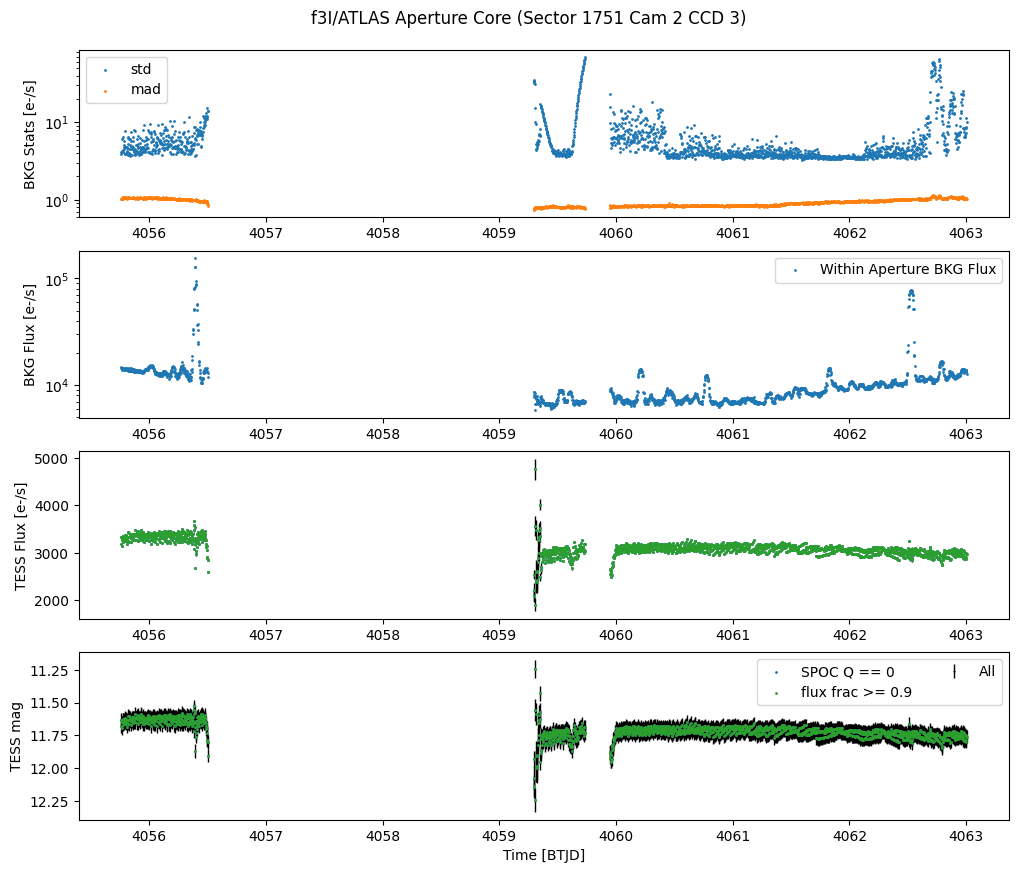

In [18]:
fig, ax = plt.subplots(4, 1, figsize=(12,10))
fig.suptitle(f"f3I/ATLAS Aperture Core (Sector {1751} Cam {2} CCD {3})", y=0.92)

# this are the background statistics which are a proxy for the background model
ax[0].scatter(lc_core["time"].btjd, lc_core["bkg_std"].value, s=1, label="std")
ax[0].scatter(lc_core["time"].btjd, lc_core["bkg_mad"].value, s=1, label="mad")

# this is the background flux estimated within the aperture
ax[1].scatter(
    lc_core["time"].btjd,
    lc_core["flux_bkg"].value,
    s=1,
    label="Within Aperture BKG Flux",
)
# ax[2].scatter(
#     lc_core["time"].btjd,
#     lc_core["flux_fraction"].value,
#     s=1,
#     label="Within Aperture BKG Flux",
# )

# we plot the flux values, all points
ax[2].errorbar(
    lc_core["time"].btjd,
    lc_core["flux"].value,
    yerr=np.array(lc_core["flux_err"].value),
    fmt=".",
    lw=1,
    ms=1,
    label="All",
    zorder=-1000,
    c="k"
)

# filter by spoc quality flag
mask = lc_core["quality"] == 0
ax[2].scatter(
    lc_core["time"][mask].btjd,
    lc_core["flux"][mask].value,
    s=1,
    c="tab:blue",
    label="SPOC Q == 0",
)

# filter by flux fraction, which account for bad pixels in the aperture
mask = lc_core["flux_fraction"] >= 0.9
ax[2].scatter(
    lc_core["time"][mask].btjd,
    lc_core["flux"][mask].value,
    s=1,
    c="tab:green",
    label="flux frac >= 0.9",
)

# we can filter fy noisy background estimates
# mask = lc_core["bkg_std"].value <= 1.5
# ax[2].scatter(lc_core["time"][mask].btjd, lc_core["flux"][mask].value, s=1, label="std(BKG) < 1.5")

# we plot the magnitude values
ax[3].errorbar(
    lc_core["time"].btjd,
    lc_core["tessmag"].value,
    yerr=np.array(lc_core["tessmag_err"]),
    fmt=".",
    lw=1,
    ms=1,
    label="All",
    zorder=-1000,
    c="k",
)

# filter by spoc quality flag
mask = (lc_core["quality"] == 0)
ax[3].scatter(
    lc_core["time"][mask].btjd,
    lc_core["tessmag"][mask].value,
    s=1,
    c="tab:blue",
    label="SPOC Q == 0",
)

# filter by flux fraction, which account for bad pixels in the aperture
mask = (lc_core["flux_fraction"] >= 0.9)
ax[3].scatter(
    lc_core["time"][mask].btjd,
    lc_core["tessmag"][mask].value,
    s=1,
    c="tab:green",
    label="flux frac >= 0.9",
)


# ax[2].set_ylim(-10, 200)
# ax[2].set_ylim(14, 18)
ax[0].legend()
ax[1].legend()
ax[3].legend(loc="best", ncols=2)
ax[-1].set_xlabel("Time [BTJD]")
ax[0].set_ylabel("BKG Stats [e-/s]")
ax[1].set_ylabel("BKG Flux [e-/s]")
ax[2].set_ylabel("TESS Flux [e-/s]")
ax[3].set_ylabel("TESS mag")
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[-1].invert_yaxis()
plt.show()

We can do similar things with the second aperture light curve (for the core + tail) and the PSF light curve, this time we use the generic file reader from `lightkurve` to load a different HDU extension

In [19]:
lc_total = lk.io.generic.read_generic_lightcurve(
    f"../../data/2026/hlsp_tess-3i_tess_ffi_3iatlas-s1751-cam2-ccd3_tess_v{version}_lc.fits",
    ext=2,
    time_format="btjd",
)

lc_psf = lk.io.generic.read_generic_lightcurve(
    f"../../data/2026/hlsp_tess-3i_tess_ffi_3iatlas-s1751-cam2-ccd3_tess_v{version}_lc.fits",
    ext=3,
    time_format="btjd",
)
lc_psf.head()

time,flux,flux_err,time_uerr,time_lerr,timecorr,cadenceno,quality,tessmag,tessmag_err,red_chi2,psf_quality,quality_fraction,n_cadences,bkg_std,bkg_mad
,electron / s,electron / s,d,d,d,,,mag,mag,,,,,electron / s,electron / s
Time,float32,float32,float32,float32,float32,int16,int32,float32,float32,float32,int16,float32,int16,float32,float32
4055.759261378877,1.6407030e+03,6.8915339e+00,———,———,5.4868632e-03,0,1000,1.2402425e+01,5.0207548e-02,3.6681839e+01,100,1.0000000e+00,1,4.0900550e+00,1.0311905e+00
4055.7615763051035,1.5944961e+03,6.7842855e+00,———,———,5.4869754e-03,1,0,1.2433441e+01,5.0212953e-02,3.7501312e+01,100,1.0000000e+00,1,3.8995125e+00,1.0331349e+00
4055.7638912312336,1.6477031e+03,6.9703426e+00,———,———,5.4870881e-03,2,0,1.2397802e+01,5.0210517e-02,3.6038658e+01,100,1.0000000e+00,1,6.1717210e+00,1.0465043e+00
4055.7662061574324,1.5843551e+03,6.8196483e+00,———,———,5.4872003e-03,3,0,1.2440369e+01,5.0217934e-02,3.7426926e+01,100,1.0000000e+00,1,4.1350369e+00,1.0223581e+00
4055.768521083494,1.6234174e+03,6.9096737e+00,———,———,5.4873126e-03,4,0,1.2413924e+01,5.0213099e-02,3.6395851e+01,100,1.0000000e+00,1,4.2086058e+00,1.0683737e+00


The total aperture extension contains the same columns as the core aperture extension. The PSf light curve contains many columns, some of these are most relevant tha others:

* **time** is the fully corrected time (mid exposure) of the photometric point in BTJD.
* **flux and flux_err** are the aperture flux values and errors for the epoch in `e/s`.
* **time_uerr and time_lerr** are the upper and lower ends of the time window used when fitting the PSF photometry to multiple cadences, effectively applying image stacking.
* **cadenceno** is the cadence number according to the FFI (or TPF) files.
* **quality** is the SPOC quality frame, similarly to the `tp` file.
* **tessmag and tessmag_err** are the magnitude values and errors in the TESS filter using the mission derived zero point (20.44)
* **red_chi2** is the reduced $\chi^2$ value for the fitted model at each cadence.
* **psf_quality** is the encoded quality for pixels used to fit the PSF model.
* **quality_fraction** is the PSF fraction when adding up all pixels used for model fitting.
* **n_cadences** is the number of cadences used when fitting the model. 
* **bkg_std and bkg_mad** are the std and mad statistics of the background pixels.

Again we can filter out bad/poor quality frames using multiple metrics such as reduced chi2, SPOC quality flags, and PSF fraction of good quality pixels.

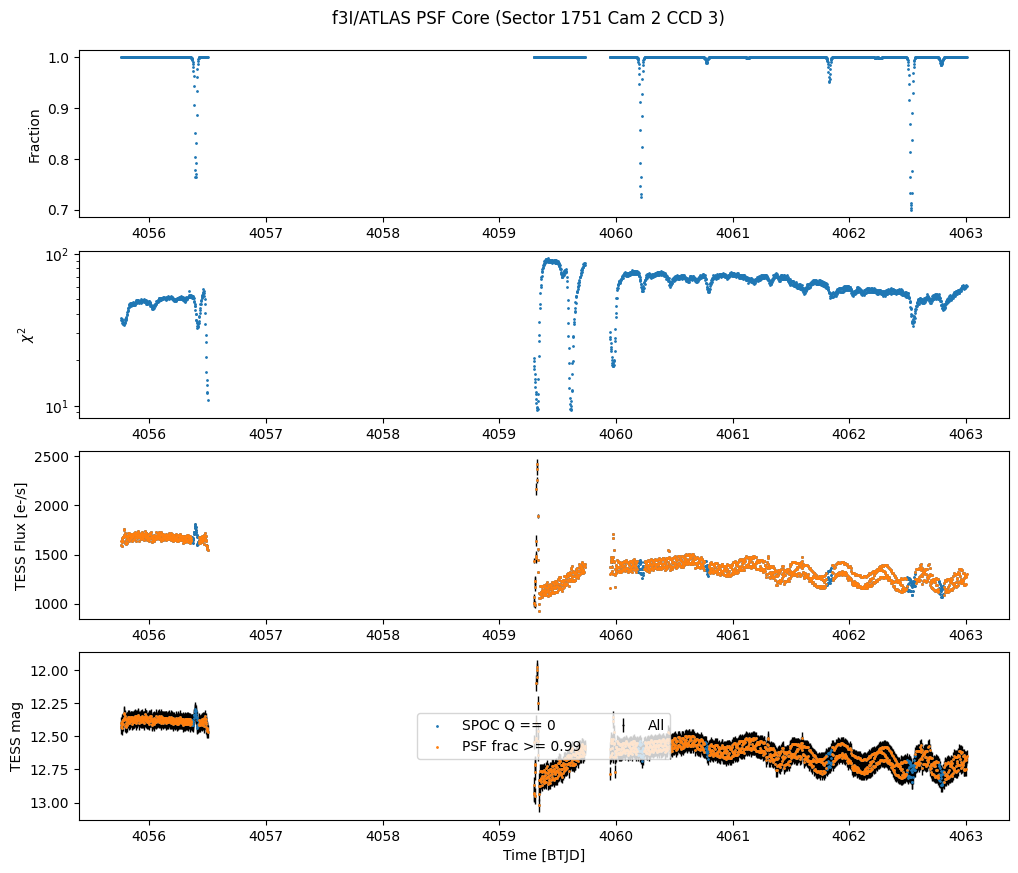

In [20]:
fig, ax = plt.subplots(4, 1, figsize=(12,10))
fig.suptitle(f"f3I/ATLAS PSF Core (Sector {1751} Cam {2} CCD {3})", y=0.92)

ax[0].scatter(lc_psf["time"].btjd, lc_psf["quality_fraction"], s=1)

ax[1].scatter(lc_psf["time"].btjd, lc_psf["red_chi2"], s=1)

ax[2].errorbar(
    lc_psf["time"].btjd,
    lc_psf["flux"].value,
    yerr=np.array(lc_psf["flux_err"]),
    fmt=".",
    lw=1,
    ms=1,
    label="All",
    zorder=-1000,
    c="k",
)

mask = lc_psf["quality"] == 0  # & (lc_psf["psf_quality"] == 0)
ax[2].scatter(
    lc_psf["time"][mask].btjd, lc_psf["flux"][mask].value, s=1, label="SPOC Q == 0"
)

mask = lc_psf["quality_fraction"] >= 0.999
ax[2].scatter(
    lc_psf["time"][mask].btjd,
    lc_psf["flux"][mask].value,
    s=1,
    label="PSF frac >= 0.99",
)

# mask = lc_psf["red_chi2"] <= 2
# ax[2].scatter(
#     lc_psf["time"][mask].btjd, lc_psf["flux"][mask].value, s=1, label=r"$\chi^{2}<2$"
# )

ax[3].errorbar(
    lc_psf["time"].btjd,
    lc_psf["tessmag"].value,
    yerr=np.array(lc_psf["tessmag_err"]),
    fmt=".",
    lw=1,
    ms=1,
    label="All",
    zorder=-1000,
    c="k",
)

mask = (lc_psf["quality"] == 0) #& (lc_psf["psf_quality"] == 0)
ax[3].scatter(lc_psf["time"][mask].btjd, lc_psf["tessmag"][mask].value, s=1, label="SPOC Q == 0")

mask = (lc_psf["quality_fraction"] >= 0.999)
ax[3].scatter(lc_psf["time"][mask].btjd, lc_psf["tessmag"][mask].value, s=1, label="PSF frac >= 0.99")

# mask = (lc_psf["red_chi2"] <= 2)
# ax[3].scatter(lc_psf["time"][mask].btjd, lc_psf["tessmag"][mask].value, s=1, label=r"$\chi^{2}<2$")

# gray bars where the asteroid crosses a background star
# ax[2].vlines(mtpf.lc["aperture"]["time"][crossing_bkg_star > 2], ymin=13, ymax=25, zorder=-1000000, color="gray", alpha=0.1, lw=0.2)

# ax[0].legend()
# ax[1].legend()
ax[3].legend(loc="center", ncols=2)
# ax[2].set_ylim(-10, 200)
# ax[3].set_ylim(14,18)
ax[-1].set_xlabel("Time [BTJD]")
ax[0].set_ylabel("Fraction")
ax[1].set_ylabel(r"$\chi^{2}$")
ax[2].set_ylabel("TESS Flux [e-/s]")
ax[3].set_ylabel("TESS mag")
ax[1].set_yscale("log")
ax[-1].invert_yaxis()

plt.show()

The $\chi^2$ metric has a high base value because the PSF model is fitted only to the core of the comet, but the metric is computed with all pixels in te cutout, therefore any diffuse signal contributes to the value. But we can still use the metric to identify badly fitted cadences using sigma clipping statistics.

We can also inspect the data in the **EXTRA** extension. One relevant array here is the `NPIX_BKGSTAR` which indicates the number of pixels in the photometric aperture which overlap with background stars. This could be a good metric to further clean the light curve for potential remaining contamination. 

In [21]:
extra = Table.read(
    f"../../data/2026/hlsp_tess-3i_tess_ffi_3iatlas-s1751-cam2-ccd3_tess_v{version}_lc.fits",
    hdu=4,
)
extra


TIME,TIMECORR,ORIGINAL_TIME,ORIGINAL_TIMECORR,CADENCENO,CORNER1,CORNER2,EPHEM1,EPHEM2,RA_PRED,DEC_PRED,NPIX_BKGSTAR_CORE,NPIX_BKGSTAR_TOTAL
"BJD - 2457000, days",d,"BJD - 2457000, days",d,,pix,pix,pix,pix,deg,deg,,
float64,float32,float64,float32,int16,int16,int16,float32,float32,float32,float32,int16,int16
4.0557593e+03,5.4868632e-03,4.0557593e+03,5.5066701e-03,0,1686,584,1.7305627e+03,6.2869098e+02,1.3053697e+02,1.6027672e+01,0,8
4.0557616e+03,5.4869754e-03,4.0557616e+03,5.5067227e-03,1,1686,584,1.7305642e+03,6.2908398e+02,1.3053473e+02,1.6028164e+01,0,8
4.0557639e+03,5.4870881e-03,4.0557639e+03,5.5067749e-03,2,1686,584,1.7305656e+03,6.2947693e+02,1.3053247e+02,1.6028656e+01,0,8
4.0557662e+03,5.4872003e-03,4.0557662e+03,5.5068270e-03,3,1686,585,1.7305670e+03,6.2986987e+02,1.3053021e+02,1.6029148e+01,0,7
4.0557685e+03,5.4873126e-03,4.0557685e+03,5.5068792e-03,4,1686,585,1.7305685e+03,6.3026282e+02,1.3052797e+02,1.6029640e+01,0,7
4.0557708e+03,5.4874253e-03,4.0557709e+03,5.5069313e-03,5,1686,586,1.7305698e+03,6.3065570e+02,1.3052571e+02,1.6030132e+01,0,6
4.0557732e+03,5.4875375e-03,4.0557732e+03,5.5069835e-03,6,1686,586,1.7305713e+03,6.3104852e+02,1.3052345e+02,1.6030624e+01,0,6
4.0557755e+03,5.4876497e-03,4.0557755e+03,5.5070361e-03,7,1686,586,1.7305726e+03,6.3144141e+02,1.3052121e+02,1.6031116e+01,0,6


## Recommended Quality Filters

To make sure we use good quality photometric data, we recommend applying the following filters for each type of photometric method

In [22]:
# core aperture
# we select cadences with high flux fraction, good quality flag
# and with background flux within 3-sigma of the clipped distribution
mask_core = (
    (lc_core["flux_fraction"] >= 0.9)
    & (lc_core["quality"] == 0)
    & ~(sigma_clip(np.array(lc_core["flux_bkg"]), sigma=3).mask)
    & ~(sigma_clip(np.array(lc_core["flux_err"]), sigma=3).mask)
)

# total aperture
mask_total = (
    (lc_total["flux_fraction"] >= 0.9)
    & (lc_total["quality"] == 0)
    # & ~(sigma_clip(np.array(lc_core["flux_bkg"]), sigma=3).mask)
    & ~(sigma_clip(np.array(lc_total["flux_err"]), sigma=3).mask)
)

# psf photometry
# we select cadences with high quality fraction and good quality flag
mask_psf = (
    (lc_psf["quality"] == 0)
    & (lc_psf["quality_fraction"] >= 0.95)
    & ~(sigma_clip(np.array(lc_psf["flux_err"]), sigma=3).mask)
)

In [23]:
# find data breaks due to diwnlink
break_points = np.where(np.diff(lc_psf["time"]) > 0.1)[0] + 1
break_points = np.concatenate(
    [[0], break_points.tolist(), [len(lc_psf["time"])]]
).ravel()

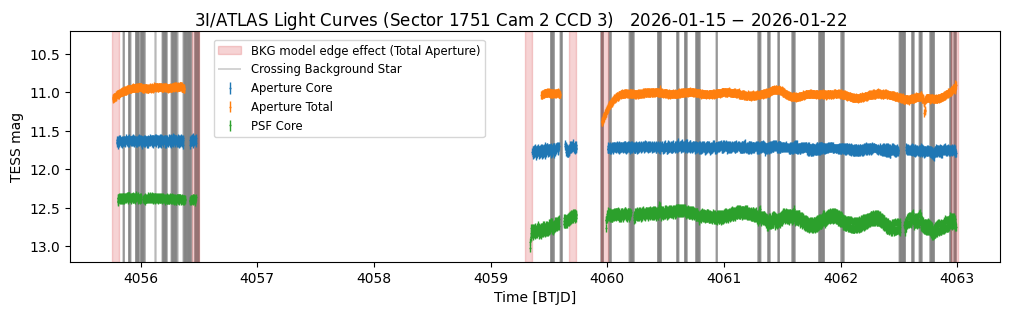

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
fig.suptitle(
    f"3I/ATLAS Light Curves (Sector {lc_core.sector} Cam {lc_core.camera} CCD {lc_core.ccd})"
    f"   {lc_core.time[0].iso[:10]} $-$ {lc_core.time[-1].iso[:10]}",
    y=0.95,
)

ax.errorbar(
    lc_core["time"][mask_core].btjd,
    np.array(lc_core["tessmag"][mask_core].value),
    yerr=np.array(lc_core["tessmag_err"][mask_core].value),
    fmt=".",
    lw=1,
    ms=1,
    label="Aperture Core",
)
ax.errorbar(
    lc_total["time"][mask_total].btjd,
    np.array(lc_total["tessmag"][mask_total].value),
    yerr=np.array(lc_total["tessmag_err"][mask_total].value),
    fmt=".",
    lw=1,
    ms=1,
    label="Aperture Total",
)
ax.errorbar(
    lc_psf["time"][mask_psf].btjd,
    np.array(lc_psf["tessmag"][mask_psf].value),
    yerr=np.array(lc_psf["tessmag_err"][mask_psf].value),
    fmt=".",
    lw=1,
    ms=1,
    label="PSF Core",
)

# we plot the time ranges affected by background model edge effects
for s, e in zip(break_points[:-1], break_points[1:]):
    ax.axvspan(
        lc_total["time"][s].value,
        lc_total["time"][s + 25].value,
        color="tab:red",
        alpha=0.2,
        label="BKG model edge effect (Total Aperture)" if s == 0 else None,
    )
    ax.axvspan(
        lc_total["time"][e - 1 - 25].value, 
        lc_total["time"][e - 1].value, 
        color="tab:red", 
        alpha=0.2, 
        # label="BKG model edge effect (Total Aperture)"
        )

# we highlight the times when the asteroid crosses background stars
ax.vlines(
    lc_core["time"][extra["NPIX_BKGSTAR_CORE"] > 3].btjd,
    # [4056],
    ymin=14,
    ymax=10,
    zorder=-1000,
    color="gray",
    alpha=0.4,
    lw=1.2,
    label="Crossing Background Star",
)

ax.legend(loc="center", bbox_to_anchor=(0.3, 0.75), ncols=1, fontsize="small")
ax.set_ylim(10.2,13.2)
# ax.set_xlim(4055.7, 4056.6)

ax.set_xlabel("Time [BTJD]")
ax.set_ylabel("TESS mag")
ax.invert_yaxis()

plt.savefig(
    "../../data/2026/figures/tess_3iatlas_spoc_s1751_lc_clean.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


There's still a jitter pattern in the core photometry due to the comet center moving from pixel to pixel.
These signal can be removed by using the centroid vectors as bases for a linear regression correction. 
For more on how to correct see the REgressionCorrector tutorials in the `lightkurve` documentation [here](https://lightkurve.github.io/lightkurve/tutorials/2-creating-light-curves/2-3-removing-scattered-light-using-regressioncorrector.html).
The smooth variation seen in the last section of the total aperture photometry is due to remaining residual light. 
We still need to understand the source of the smooth variation in the PSF core photometry during the last segment, but we believe is not astrophysical and comes from a combination of the residual scattered light and position offset, as the PSF-fitting algorithm assumes the nucleus location is accurate, which is not entirely true. The PSF-fitting is more sensitive to less accurate positions and small background residuals.

In [25]:
print(
    f'T(Ap_core)  = {np.median(np.array(lc_core["tessmag"][mask_core].value)):.2f} +- '
    f'{median_absolute_deviation(np.array(lc_core["tessmag"][mask_core].value)):.2f}'
    )
print(
    f'T(Ap_total) = {np.median(np.array(lc_total["tessmag"][mask_total].value)):.2f} +- '
    f'{median_absolute_deviation(np.array(lc_total["tessmag"][mask_total].value)):.2f}'
    )
print(
    f'T(PSF_core) = {np.median(np.array(lc_psf["tessmag"][mask_psf].value)):.2f} +- '
    f'{median_absolute_deviation(np.array(lc_psf["tessmag"][mask_psf].value)):.2f}'
    )


T(Ap_core)  = 11.72 +- 0.02
T(Ap_total) = 11.02 +- 0.02
T(PSF_core) = 12.62 +- 0.07


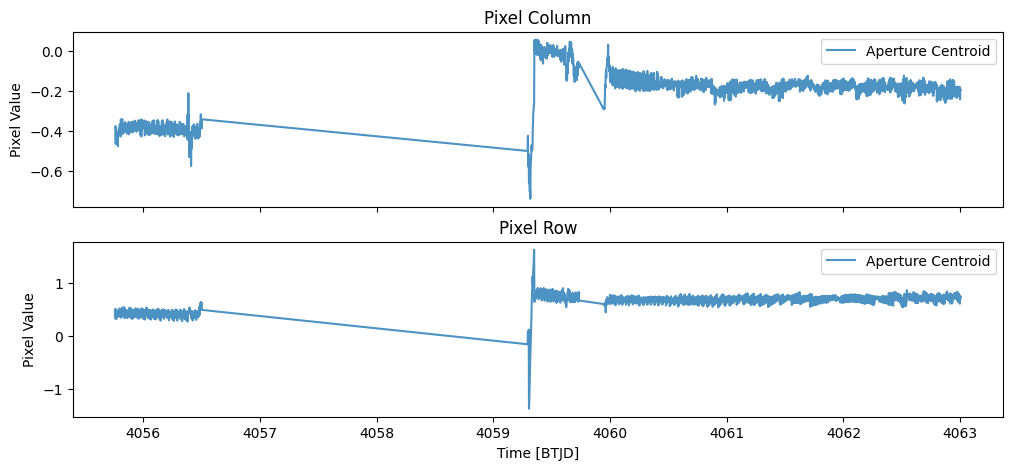

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
ax[0].set_title("Pixel Column")

ax[0].plot(
    lc_core.time.btjd,
    extra["EPHEM1"].value - lc_core.centroid_col.data,
    c="tab:blue",
    alpha=0.8,
    label="Aperture Centroid",
)
ax[0].legend()
ax[1].set_title("Pixel Row")
ax[1].errorbar(
    lc_core.time.btjd,
    extra["EPHEM2"].value - lc_core.centroid_row.data,
    c="tab:blue",
    alpha=0.8,
    label="Aperture Centroid",
)
ax[1].legend()
ax[-1].set_xlabel("Time [BTJD]")
ax[0].set_ylabel("Pixel Value")
ax[1].set_ylabel("Pixel Value")

plt.show()
